In [1]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Extrapolación a frecuencia diferente

In [2]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  # read_map loads the first column

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/michellemora/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


    Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [3]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Tiempo(s): 1.6972458362579346


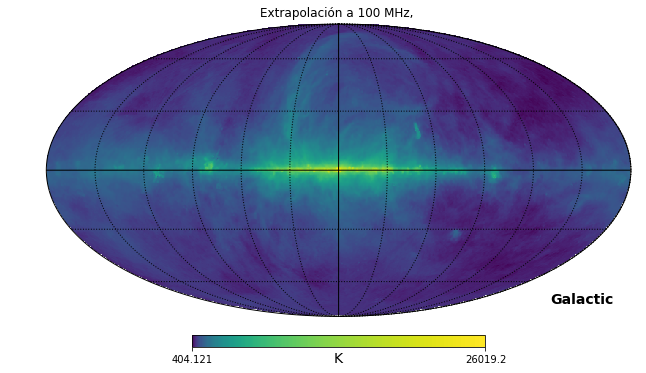

In [4]:
T_100=T_freq(2.54,408,100,T_Hmap)   #Scale (100 MHz)
start = time.time()
hp.mollview(T_100,
    coord=["G"],
    title="Extrapolación a 100 MHz, ",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels
end = time.time()
print('Tiempo(s):',end - start)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


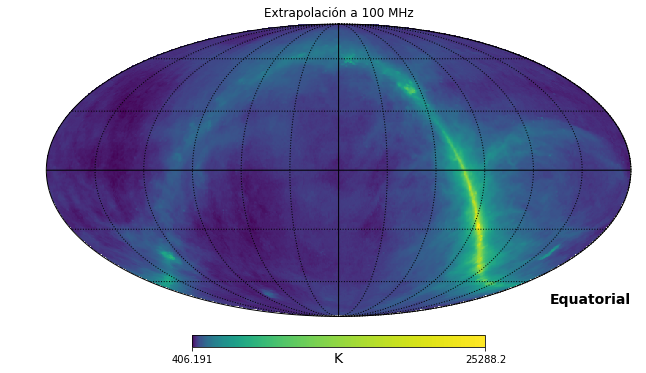

In [5]:
hp.mollview(T_100,
    coord=["G",'Equatorial'],
    title="Extrapolación a 100 MHz",
    unit="K",
    norm="log")
hp.graticule() #adds meridians and parallels

### Galactic longitude (l) and latitude (b)

In [6]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

nside, npix, l, b

(512,
 3145728,
 array([ 45., 135., 225., ..., 135., 225., 315.]),
 array([ 89.90862927,  89.90862927,  89.90862927, ..., -89.90862927,
        -89.90862927, -89.90862927]))

### Time and location for horizontal coordinates 

In [7]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

dt = TimeDelta(60*60, format='sec')    #dt=1 hr
times=start_t + dt*linspace(0,24,24)

altaz = AltAz(location=Alma_loc, obstime=times)

### Dynamic Spectra

Temperature matrix for the dynamic spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)
\end{pmatrix}$$

In [8]:
freqs1=arange(50,160,10) #MHz
freqs2=arange(50,155,5)

In [11]:
def Temps(fs,ts):  
    '''Takes frequencies (fs) and times (ts) and returns the Temperature matriz'''
    
    start = time.time()
    Temps=zeros((len(ts),len(fs)))
    for i in range (len(ts)):
        aa_coord=g_coord.transform_to(altaz[i])   #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        for j in range (len(fs)):
            T_f=T_freq(2.54,408,fs[j],T_sky)      #Extrapolation
            Temps[-i,j]=mean(T_f)                 #Mean temperature (bottom to top)
    end = time.time()
    print('Tiempo recorrido(s):',end - start)  
    return Temps

In [ ]:
Temps1=Temps(freqs1,times)

In [ ]:
Temps2=Temps(freqs2,times)

In [ ]:
altaz_sun=get_sun(times).transform_to(altaz)    #LST
figure(figsize=(2,4))
plot(altaz_sun.alt,times.to_datetime())

In [ ]:
figure(figsize=(13,7))
subplot(1,2,1)
pcolormesh(freqs1,times.to_datetime(), Temps1,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=10 MHz"),xlabel('freq (MHz)'),ylabel('Hour')
subplot(1,2,2)
pcolormesh(freqs2,times.to_datetime(), Temps2,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("dfreq=5 MHz"),xlabel('freq (MHz)')